In [1]:
import pandas as pd
from zipfile import ZipFile
from zipfile import is_zipfile
import io
import numpy as np
from PIL import Image
import time
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg 
import glob
import cv2
from keras import models
from keras import layers
import shutil
import os
import glob
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model

/home/g404tests/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### Definición del problema

A partir de un conjunto de imágenes de tejido mamario se pretende construír una red neuronal que sea capaz de predecir con un porcentaje alto de probabilidad si un tejido dado es susceptible considerarse o no canceroso.


#### Exploración de los datos
Se han dividido las imágenes en la siguiente estructura de directorios:

train/cancer

train/no_cancer

val/cancer

val/no_cancer



A continuación se muestra el número de imágenes de cada directorio

In [2]:
imageTrainCancer = glob.glob( 'train/cancer/*.tif', recursive=True)
imageTrainNoCancer = glob.glob( 'train/no_cancer/*.tif', recursive=True)
imageValCancer = glob.glob( 'val/cancer/*.tif', recursive=True)
imageValNoCancer = glob.glob( 'val/no_cancer/*.tif', recursive=True)
imageTest = glob.glob( 'test/*.tif', recursive=True)

print('Imágenes de train cancer '+str(len(imageTrainCancer)))
print('Imágenes de train no cancer '+str(len(imageTrainNoCancer)))
print('Imágenes de val cancer '+str(len(imageValCancer)))
print('Imágenes de val no cancer '+str(len(imageValNoCancer)))
print('Imágenes de test '+str(len(imageTest)))


Imágenes de train cancer 65776
Imágenes de train no cancer 96791
Imágenes de val cancer 23341
Imágenes de val no cancer 34117
Imágenes de test 57458


Tal y como se puede observar, en los grupos de train y validation, el porcentaje de imágenes cancersosas es del 59%.
Ambos grupos están creados con la misma proporción de casos cancerosos/no cancerosos.

##### Forma de las imágenes

In [3]:
imagenEjemlo=cv2.imread(imageTrainCancer[0])
print(imagenEjemlo.shape)

(96, 96, 3)


Tal y como se aprecia, cada imágen tiene la siguiente forma: (96,96,3)

#### Ejemplos de imágenes con tejido canceroso

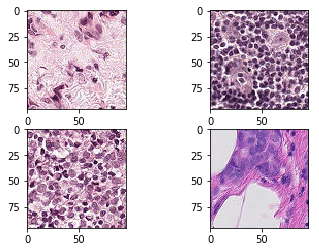

In [4]:
fig, axes = plt.subplots(2,2)
i=0
for i in range(4):    
    imagenCancerosa=imageTrainCancer[i]
    img=mpimg.imread(imagenCancerosa,'r')
    axes[i//2,i%2].imshow(img)
    plt.imshow(img)
    i+=1

#### Ejemplos de imágenes con tejido no canceroso

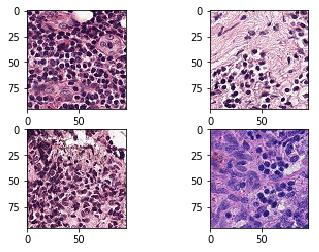

In [5]:
fig, axes = plt.subplots(2,2)
i=0
for i in range(4):    
    imagenCancerosa=imageTrainNoCancer[i]
    img=mpimg.imread(imagenCancerosa,'r')
    axes[i//2,i%2].imshow(img)
    plt.imshow(img)
    i+=1

### Creación y ejecución de modelo de predicción 

In [3]:
#Constantes
IMAGES_TRAIN=162566
IMAGES_VAL=57458
IMAGES_TEST=57458

#### Funciones para generadores de imágenes

In [4]:
def crearGeneradores(batch_size):
    datagen = ImageDataGenerator(rescale=1.0/255) #Se aplica normalización
    train_gen = datagen.flow_from_directory('train',
                                            target_size=(96,96),
                                            batch_size=batch_size,
                                            class_mode='categorical')

    val_gen = datagen.flow_from_directory('val',
                                            target_size=(96,96),
                                            batch_size=batch_size,
                                            class_mode='categorical')

   
    return train_gen, val_gen

def crearGeneradorTest():
    datagen = ImageDataGenerator(rescale=1.0/255) #Se aplica normalización
    test_gen = datagen.flow_from_directory('val',
                                            target_size=(96,96),
                                            batch_size=1,
                                            class_mode='categorical',
                                            shuffle=False)
    return test_gen

#### Función para visualizar el modelo

In [5]:
def visualizarModelo(history):
  #accuracy
    epochs = np.arange(1,len(history.history['acc'])+1)
    plt.title('Accuracy over training')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.plot(epochs,history.history['acc'],'r',label='training accuracy')
    plt.plot(epochs,history.history['val_acc'],'b',label='validation accuracy')
    plt.legend(loc='best')
    plt.show()
  
    #loss
    epochs = np.arange(1,len(history.history['loss'])+1)
    plt.title('Loss over training')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.plot(epochs,history.history['loss'],'r',label='training loss')
    plt.plot(epochs,history.history['val_loss'],'b',label='validation loss')
    plt.legend(loc='best')
    plt.show()

### Creación de modelo Residual 
Se ha usado como referencia:

https://github.com/priya-dwivedi/Deep-Learning/blob/master/resnet_keras/Residual_Networks_yourself.ipynb
https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33

In [30]:
def identity_block(X, f, filters, stage, block):
  
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    

    F1, F2, F3 = filters
    
    X_shortcut = X
    
   
    X = layers.Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a')(X)
    X = layers.BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = layers.Activation('relu')(X)

    X = layers.Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b')(X)
    X = layers.BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = layers.Activation('relu')(X)

    
    X = layers.Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c')(X)
    X = layers.BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)


    X = layers.Add()([X, X_shortcut])
    X = layers.Activation('relu')(X)
    
    
    return X

In [29]:
def convolutional_block(X, f, filters, stage, block, s = 2):    
    
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    F1, F2, F3 = filters
    
    
    X_shortcut = X

   
    X = layers.Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a')(X)
    X = layers.BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = layers.Activation('relu')(X)

    X = layers.Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b')(X)
    X = layers.BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = layers.Activation('relu')(X)


    X = layers.Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c')(X)
    X = layers.BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)


    # SHORTCUT 
    X_shortcut = layers.Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1')(X_shortcut)
    X_shortcut = layers.BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

   
    # Se añade el shortcut
    X = layers.Add()([X, X_shortcut])
    X = layers.Activation('relu')(X)
    
    
    return X

In [8]:
from keras.layers import Input
from keras.models import Model
from keras import optimizers

#Quitar el parámetro de dropout. NO se está utilizando
def crearModeloResNetBasedX(dropout=0.3,optimizerType='Adam'):   
        
    X_input = Input(shape=(96,96,3))
    
    # Zero-Padding
    X = layers.ZeroPadding2D((3, 3))(X_input)
       
        
    X = layers.Conv2D(32,(3,3),input_shape=(96,96,3))(X_input)   
    X = layers.BatchNormalization(axis=3, name='bn_conv1')(X)
    X = layers.Activation('relu')(X)
    X = layers.MaxPooling2D((3, 3), strides=(2, 2))(X)
   
    
    X = convolutional_block(X, f=3, filters=[32, 32, 64], stage=2, block='a', s=1)
    X = identity_block(X, 3, [32, 32, 64], stage=2, block='b')
    X = identity_block(X, 3, [32, 32, 64], stage=2, block='c')
    
    X = convolutional_block(X, f = 3, filters = [64, 64, 128], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [64, 64, 128], stage=3, block='b')
    X = identity_block(X, 3, [64, 64, 128], stage=3, block='c')
    X = identity_block(X, 3, [64, 64, 128], stage=3, block='d')

        
    X = convolutional_block(X, f = 3, filters = [128,128,256], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [128,128,256], stage=4, block='b')
    X = identity_block(X, 3, [128,128,256], stage=4, block='c') 
    
       

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = layers.AveragePooling2D((2,2), name="avg_pool")(X)
    
    
    X = layers.Flatten()(X)
    X = layers.Dense(2, activation='sigmoid')(X)
    
  

    model = Model(inputs=X_input, outputs= X)
    
    if optimizerType=='Adam':
        optimizer = optimizers.Adam(lr=0.0001)
    elif optimizerType=='SGD':
        optimizer = optimizers.SGD(lr=0.0001, momentum=0.9, nesterov=True)
    
    
    
    model.compile(optimizer=optimizer,
               loss='categorical_crossentropy',
               metrics=['accuracy'])  
    
              
    return model

In [9]:
BATCH_SIZE = 100 
train_gen,val_gen=crearGeneradores(BATCH_SIZE)

Found 162567 images belonging to 2 classes.
Found 57458 images belonging to 2 classes.


In [10]:
from keras.layers import Input, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

DROPOUT = 0.3
modeloResX=crearModeloResNetBasedX(DROPOUT,'Adam')

Epoch 1/30
1625/1625 [==============================] - 3703s 2s/step - loss: 0.4078 - acc: 0.8215 - val_loss: 0.3683 - val_acc: 0.8460
Epoch 2/30
1625/1625 [==============================] - 3596s 2s/step - loss: 0.3352 - acc: 0.8577 - val_loss: 0.3201 - val_acc: 0.8785
Epoch 3/30
1625/1625 [==============================] - 3444s 2s/step - loss: 0.2858 - acc: 0.8823 - val_loss: 0.3442 - val_acc: 0.8585

Epoch 00003: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
Epoch 4/30
1625/1625 [==============================] - 3483s 2s/step - loss: 0.2242 - acc: 0.9069 - val_loss: 0.2350 - val_acc: 0.9046
Epoch 5/30
1625/1625 [==============================] - 3449s 2s/step - loss: 0.2100 - acc: 0.9136 - val_loss: 0.2290 - val_acc: 0.9077
Epoch 6/30
1625/1625 [==============================] - 3430s 2s/step - loss: 0.2008 - acc: 0.9172 - val_loss: 0.2317 - val_acc: 0.9049

Epoch 00006: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
Epoch 7/30
1625/1625 [

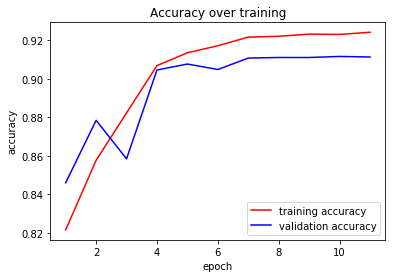

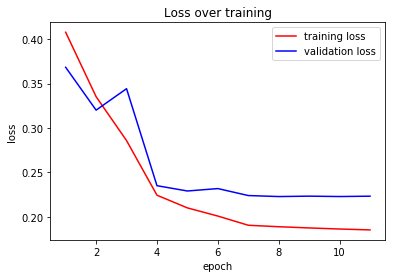

In [11]:
BATCH_SIZE = 100
earlystopper = EarlyStopping(monitor='val_loss', patience=3, verbose=2, restore_best_weights=True)
reduce = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)
#Mejor modelo
mcp_save = ModelCheckpoint('Modelo_ResX.h5', save_best_only=True, monitor='val_loss', mode='min')
#Modelo guardado en cada epoch (dado que el kernel se reinicia bastante)
mcp_save_tmp = ModelCheckpoint('Modelo_ResX_tmp.h5', save_best_only=False, monitor='val_loss', mode='min')

history = modeloResX.fit_generator(train_gen, steps_per_epoch=IMAGES_TRAIN//BATCH_SIZE, 
                    validation_data=val_gen,
                    validation_steps=IMAGES_VAL//BATCH_SIZE,
                    callbacks = [reduce, earlystopper, mcp_save, mcp_save_tmp],            
                    epochs=30, verbose=1, workers=4)

visualizarModelo(history)

Se aprecian unos resultados algo inferiores al modelo secuencial

In [7]:
modeloResX=load_model('Modelo_ResX.h5')
test_gen=crearGeneradorTest()

Found 57458 images belonging to 2 classes.


In [8]:
loss,accuracy = modeloResX.evaluate_generator(test_gen)
print('loss {} accuracy {}'.format(loss,accuracy))

loss 0.22322578066155724 accuracy 0.9108914337429078


In [9]:
modeloResX.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 94, 94, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 94, 94, 32)   128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 94, 94, 32)   0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [10]:
predictions = modeloResX.predict_generator(test_gen, steps=IMAGES_VAL, verbose=1)
print(len(predictions))

57458/57458 [==============================] - 5395s 94ms/step
57458


In [11]:
np.save('predictionsResX.npy', predictions) 

In [12]:
predictions.shape

(57458, 2)

In [13]:
test_gen.class_indices

{'cancer': 0, 'no_cancer': 1}

In [14]:
df_preds = pd.DataFrame(predictions, columns=['cancer', 'no_cancer'])
val_archivos = test_gen.filenames
print(len(df_preds))
df_preds['archivos'] = val_archivos
df_preds.head(5)

57458


,cancer,no_cancer,archivos
0,0.983619,0.043039,cancer/00001b2b5609af42ab0ab276dd4cd41c3e7745b...
1,0.969756,0.054314,cancer/0000da768d06b879e5754c43e2298ce48726f72...
2,0.668784,0.120184,cancer/00014e39b5df5f80df56f18a0a049d1cc6de430...
3,0.999993,0.013281,cancer/0001a2bc5d4aa55989f014bfad74a95ac3dfff5...
4,0.456840,0.124700,cancer/0002d959eecbd8d7f6614fdd513154e8e0e8e96...


In [15]:
from sklearn.metrics import roc_auc_score
roc_auc_score(test_gen.classes, df_preds['no_cancer'])

0.9375380002717659

In [17]:
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
val_labels = test_gen.classes
val_labels.shape
matriz_confusion = confusion_matrix(val_labels, predictions.argmax(axis=1))
print (matriz_confusion)

[[20816  2525]
 [ 2595 31522]]


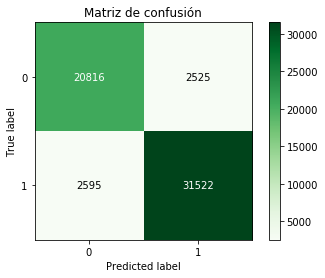

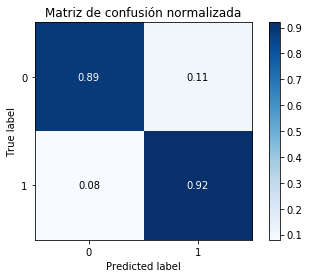

In [18]:
skplt.metrics.plot_confusion_matrix(val_labels, predictions.argmax(axis=1), normalize=False, title='Matriz de confusión',cmap=plt.cm.Greens)
skplt.metrics.plot_confusion_matrix(val_labels, predictions.argmax(axis=1), normalize=True, title='Matriz de confusión normalizada')

In [19]:
from sklearn.metrics import classification_report

y_pred_binary = predictions.argmax(axis=1)
report = classification_report(test_gen.classes, y_pred_binary, target_names=['cancer','no_cancer'])
print("Obtención de métricas:\r\n")
print(report)

Obtención de métricas:

             precision    recall  f1-score   support

     cancer       0.89      0.89      0.89     23341
  no_cancer       0.93      0.92      0.92     34117

avg / total       0.91      0.91      0.91     57458



In [20]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
false_positive_rate, true_positive_rate, threshold = roc_curve(test_gen.classes, predictions.argmax(axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)


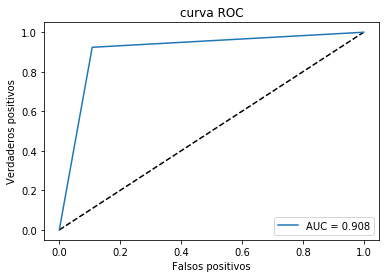

In [21]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('Falsos positivos')
plt.ylabel('Verdaderos positivos')
plt.title('curva ROC')
plt.legend(loc='best')
plt.show()


### Modificación del modelo

In [48]:
from keras.layers import Input
from keras.models import Model
from keras import optimizers
def crearModeloResNetBasedMod(dropout=0.3,optimizerType='Adam'):   
        
    X_input = Input(shape=(96,96,3))
    
    # Zero-Padding
    X = layers.ZeroPadding2D((3, 3))(X_input)
       
        
    X = layers.Conv2D(32,(3,3),input_shape=(96,96,3))(X_input)   
    X = layers.BatchNormalization(axis=3, name='bn_conv1')(X)
    X = layers.Activation('relu')(X)
    X = layers.MaxPooling2D((3, 3), strides=(2, 2))(X)
       
    
    X = convolutional_block(X, f=3, filters=[32, 32, 32], stage=2, block='a', s=1)   
    X = convolutional_block(X, f = 3, filters = [64, 64, 64], stage = 3, block='a', s = 2)        
    X = convolutional_block(X, f = 3, filters = [128,128,128], stage = 4, block='a', s = 2) 
    X = convolutional_block(X, f = 3, filters = [256,256,256], stage = 5, block='a', s = 2)

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = layers.AveragePooling2D((2,2), name="avg_pool")(X)
    
    
    x = layers.Dropout(dropout)
    X = layers.Flatten()(X)
    x = layers.Dense(64,activation='relu')
    x = layers.Dropout(dropout)
    X = layers.Dense(2, activation='sigmoid')(X)
    
  

    model = Model(inputs=X_input, outputs= X)
    
    if optimizerType=='Adam':
        optimizer = optimizers.Adam(lr=0.0001)
    elif optimizerType=='SGD':
        optimizer = optimizers.SGD(lr=0.0001, momentum=0.9, nesterov=True)
    
    
    
    model.compile(optimizer=optimizer,
               loss='categorical_crossentropy',
               metrics=['accuracy'])  
    
              
    return model

In [41]:
BATCH_SIZE = 100 
train_gen,val_gen=crearGeneradores(BATCH_SIZE)

Found 162567 images belonging to 2 classes.
Found 57458 images belonging to 2 classes.


In [52]:
from keras.layers import Input, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

DROPOUT = 0.2
modeloResMod=crearModeloResNetBasedMod(DROPOUT,'Adam')

Epoch 1/30
1625/1625 [==============================] - 1827s 1s/step - loss: 0.3733 - acc: 0.8352 - val_loss: 0.3631 - val_acc: 0.8491
Epoch 2/30
1625/1625 [==============================] - 1838s 1s/step - loss: 0.2894 - acc: 0.8765 - val_loss: 0.2863 - val_acc: 0.8850
Epoch 3/30
1625/1625 [==============================] - 1841s 1s/step - loss: 0.2342 - acc: 0.9035 - val_loss: 0.3529 - val_acc: 0.8559

Epoch 00003: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
Epoch 4/30
1625/1625 [==============================] - 1834s 1s/step - loss: 0.1688 - acc: 0.9337 - val_loss: 0.2336 - val_acc: 0.9082
Epoch 5/30
1625/1625 [==============================] - 1808s 1s/step - loss: 0.1545 - acc: 0.9406 - val_loss: 0.2331 - val_acc: 0.9105
Epoch 6/30
1625/1625 [==============================] - 1803s 1s/step - loss: 0.1464 - acc: 0.9445 - val_loss: 0.2374 - val_acc: 0.9083

Epoch 00006: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
Epoch 7/30
1625/1625 [

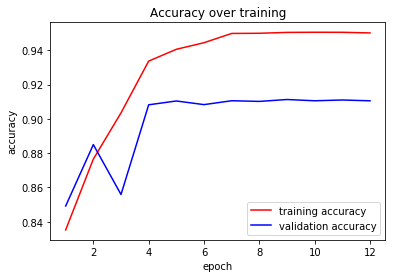

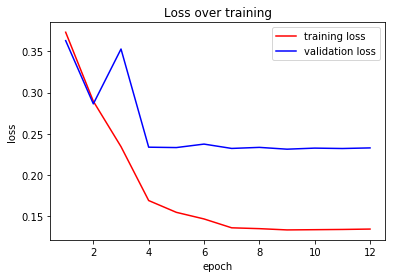

In [53]:
BATCH_SIZE = 100
earlystopper = EarlyStopping(monitor='val_loss', patience=3, verbose=2, restore_best_weights=True)
reduce = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)
#Mejor modelo
mcp_save = ModelCheckpoint('modeloResMod.h5', save_best_only=True, monitor='val_loss', mode='min')
#Modelo guardado en cada epoch (dado que el kernel se reinicia bastante)
mcp_save_tmp = ModelCheckpoint('modeloResMod_tmp.h5', save_best_only=False, monitor='val_loss', mode='min')

history = modeloResMod.fit_generator(train_gen, steps_per_epoch=IMAGES_TRAIN//BATCH_SIZE, 
                    validation_data=val_gen,
                    validation_steps=IMAGES_VAL//BATCH_SIZE,
                    callbacks = [reduce, earlystopper, mcp_save, mcp_save_tmp],            
                    epochs=30, verbose=1, workers=4)

visualizarModelo(history)